In [1]:
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

2024-08-10 14:45:39.010102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 14:45:39.010234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 14:45:39.127745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Defining some paths and constants for later use

dataset_path = pathlib.Path("../input/cnrpark-ext")
model_weight_path = pathlib.Path("../input/weight-model1/model/cp.weights.h5")

CNR_Park_patches_path = dataset_path / pathlib.Path("CNRPark-Patches-150x150")
CNR_EXT_patches_path = dataset_path / pathlib.Path("CNR-EXT-Patches-150x150")

CNR_metadata_path = dataset_path / 'CNRParkEXT.csv'

CNR_EXT_images_path = dataset_path / "CNR-EXT_FULL_IMAGE_1000x750"

CAMERAS = [f'camera{i+1}' for i in range(9)]
SEASONS = ['OVERCAST', 'RAINY', 'SUNNY']
DATES_BY_SEASONS = {season: os.listdir(CNR_EXT_patches_path / 'PATCHES' / SEASONS[0]) for season in SEASONS}

camera_metadata_paths = [CNR_EXT_images_path / f'{camera}.csv' for camera in CAMERAS]

In [3]:
patches_data_df = pd.read_csv(CNR_EXT_patches_path / 'LABELS' / 'all.txt', sep=' ', header=None)
patches_data_df.columns = ['path', 'label']

patches_data_train_df = pd.read_csv(CNR_EXT_patches_path / 'LABELS' / 'train.txt', sep=' ', header=None)
patches_data_train_df.columns = ['path', 'label']

patches_data_test_df = pd.read_csv(CNR_EXT_patches_path / 'LABELS' / 'test.txt', sep=' ', header=None)
patches_data_test_df.columns = ['path', 'label']

patches_data_train_df

,path,label
0,SUNNY/2015-11-12/camera8/S_2015-11-12_12.26_C0...,1
1,OVERCAST/2015-11-25/camera8/O_2015-11-25_10.00...,1
2,OVERCAST/2015-12-19/camera4/O_2015-12-19_12.51...,0
3,RAINY/2015-11-21/camera7/R_2015-11-21_13.18_C0...,0
4,OVERCAST/2015-11-20/camera6/O_2015-11-20_11.17...,1
...,...,...
94488,RAINY/2016-01-14/camera7/R_2016-01-14_14.10_C0...,1
94489,OVERCAST/2015-11-29/camera4/O_2015-11-29_11.47...,1
94490,SUNNY/2015-11-12/camera2/S_2015-11-12_11.14_C0...,1
94491,OVERCAST/2015-11-25/camera1/O_2015-11-25_14.10...,1


In [4]:
'''
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_data = data_generator.flow_from_dataframe(patches_data_train_df,
                                                directory=CNR_EXT_patches_path / "PATCHES",
                                                x_col='path',
                                                y_col='label',
                                                class_mode='raw')

test_data = data_generator.flow_from_dataframe(patches_data_test_df,
                                                directory=CNR_EXT_patches_path / "PATCHES",
                                                x_col='path',
                                                y_col='label',
                                                class_mode='raw')
'''

'\ndata_generator = tf.keras.preprocessing.image.ImageDataGenerator(\n    rescale=1./255\n)\n\ntrain_data = data_generator.flow_from_dataframe(patches_data_train_df,\n                                                directory=CNR_EXT_patches_path / "PATCHES",\n                                                x_col=\'path\',\n                                                y_col=\'label\',\n                                                class_mode=\'raw\')\n\ntest_data = data_generator.flow_from_dataframe(patches_data_test_df,\n                                                directory=CNR_EXT_patches_path / "PATCHES",\n                                                x_col=\'path\',\n                                                y_col=\'label\',\n                                                class_mode=\'raw\')\n'

In [5]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
    include_top = False
)
MobileNetV2.trainable = False
MobileNetV2.summary()

/tmp/ipykernel_24/3478804400.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2 = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model

In [6]:
inp = tf.keras.layers.Input((256, 256, 3))
x = MobileNetV2(inp)
#x = tf.keras.layers.GlobalAveragePooling2D(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inp, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,310,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,568,801 (13.61 MB)

 Trainable params: 1,310,785 (5.00 MB)

 Non-trainable params: 2,258,016 (8.61 MB)

In [7]:
checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [8]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [9]:
#history = model.fit(train_data,
#                    callbacks=[cp_callback],
#                    epochs=2)

In [10]:
model.load_weights(model_weight_path)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
#model.evaluate(test_data)

In [12]:
def predict(model, row):
    image_path = CNR_EXT_patches_path / "PATCHES" / row['path']
    
  # Load the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256, 3))
    

  # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    plt.imshow(img)
    print(img_array.shape)

  # Rescale the image by dividing by 255
    img_array /= 255.0
    img_array = img_array.reshape((1,256,256,3))
    
    pred = model.predict(img_array)
    print(pred, row['label'])

(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1723301160.462646      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[[0.9999864]] 1


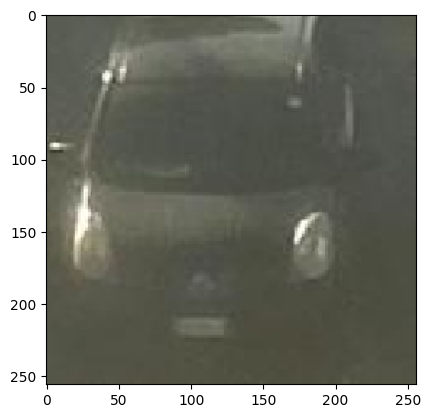

In [13]:
predict(model, patches_data_train_df.iloc[25,:])

In [14]:
patches_data_test_df['label'].value_counts()

label
1    18276
0    13549
Name: count, dtype: int64

In [15]:
df = pd.read_csv('/kaggle/input/cnrpark-ext/CNR-EXT_FULL_IMAGE_1000x750/camera1.csv')

# Display the first few rows
print(df.head())

   SlotId     X     Y    W    H
0     603  1034  1640  240  240
1     604   718  1320  240  240
2     605   504  1126  200  200
3     606   306   944  180  180
4     607   169   811  150  150


In [16]:
original_width = 2592
original_height = 1944

# Target image dimensions
target_width = 1000
target_height = 750
scale_x = target_width / original_width
scale_y = target_height / original_height
Xarr=df['X'].to_numpy()
Xnew_arr=Xarr*scale_x
Yarr=df['Y'].to_numpy()
Ynew_arr=Yarr*scale_y
Warr=df['W'].to_numpy()
Wnew_arr=Warr*scale_x
Harr=df['H'].to_numpy()
Hnew_arr=Harr*scale_y

df['newX']=Xnew_arr
df['newY']=Ynew_arr
df['newW']=Wnew_arr
df['newH']=Hnew_arr
df['newX'] = df['newX'].astype(int)
df['newY'] = df['newY'].astype(int)
df['newW'] = df['newW'].astype(int)
df['newH'] = df['newH'].astype(int)

In [17]:
df

,SlotId,X,Y,W,H,newX,newY,newW,newH
0,603,1034,1640,240,240,398,632,92,92
1,604,718,1320,240,240,277,509,92,92
2,605,504,1126,200,200,194,434,77,77
3,606,306,944,180,180,118,364,69,69
4,607,169,811,150,150,65,312,57,57
5,608,15,673,150,150,5,259,57,57
6,184,2032,1652,240,240,783,637,92,92
7,185,1890,1404,200,200,729,541,77,77
8,186,1620,1338,160,160,625,516,61,61
9,187,1412,1254,160,160,544,483,61,61


In [18]:
from PIL import Image
def image_to_array(image_path):

    # Open the image
    image = Image.open(image_path)
    
    # Convert image to NumPy array
    image_array = np.array(image)
    
    
    
    return image_array
def extract_patch(image_array, coordinates):

    x_start, y_start, width, height = coordinates
    x_end = x_start + width
    y_end = y_start + height
    
    # Extract the patch using slicing
    patch = image_array[y_start:y_end, x_start:x_end]
    
    return patch


In [19]:
imagepathman='/kaggle/input/cnrpark-ext/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/RAINY/2015-12-22/camera1/2015-12-22_1148.jpg'

In [20]:
camera1=image_to_array(imagepathman)

In [21]:
def predict_from_img(model,img,show_img=False):
    input_size_1, input_size_2, channels = img.shape
    output_size = 256
    bin_size_1, bin_size_2 = input_size_1 // output_size, input_size_2 // output_size
    img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
    img_arr = np.array(img, dtype='float32')
    img_arr /= 255.0
    img_arr = img_arr.reshape((1,256,256,3))
    
    pred = model.predict(img_arr, verbose=0)
    if(show_img):
        plt.imshow(img)
        plt.show()
        print(pred)
    return pred

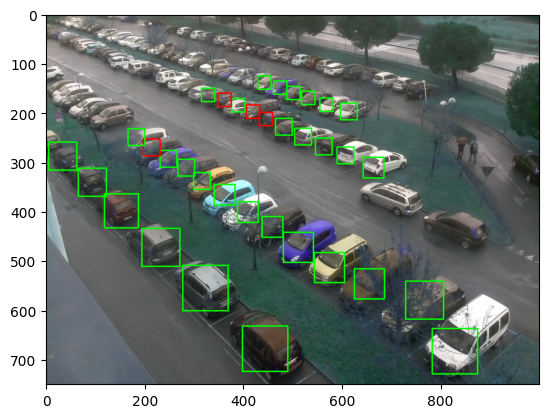

In [22]:
img=cv2.imread(imagepathman)
plt.imshow(img)
count=0
for index,row in df.iterrows():
    columns_of_interest = ['newX', 'newY', 'newW', 'newH']
    row_tuple = tuple(df.loc[index, columns_of_interest])
    X,Y,W,H=row_tuple
    array1=extract_patch(camera1, row_tuple)
    p=predict_from_img(model,array1)
#     d[df.loc[index,'SlotId']]=array1
    if p>=0.75:
        count+=1
        img=cv2.rectangle(img,(X,Y),(X+W,Y+H),(0, 255, 0),2)
    else:
        img=cv2.rectangle(img,(X,Y),(X+W,Y+H),(255, 0, 0),2)
        continue
count
plt.imshow(img)
